# Dhruv Rana #

#### Remove Previous Video Folder an make a new one ####

In [1]:
import os
import shutil

if os.path.exists("video"): 
    shutil.rmtree("video")
    
os.mkdir("video")

#### Import Packages

In [2]:
import gym
import math
import random
import numpy as np

import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from gym.wrappers.monitoring.video_recorder import VideoRecorder

env = gym.make('CartPole-v1', render_mode='rgb_array')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for inference")

# Trying to make the code a bit deterministic
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

Using cuda for infrence


[0]

#### Create Memory to save transitions of states of env.

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

#Create memory that can store the tranisitions between states. Only the amount capacity speciifed can be held
#We will use this memeory in optimization to optimize our network and reduce the loss.

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

##### Build Deep Network (using observations instead of pictures)

In [4]:
# Using given torch modules we will create our own newteok from scratch.
# Our output should be equal to our action space which is 2
# our input should take obervation space dimensions  
# We will also need a forward function when evaluating the next action of a given state
# This will also be used for optimization

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#### Hyperparameters

In [6]:
BATCH_SIZE = 128 # BATCH_SIZE is the number of transitions sampled from the replay buffer
GAMMA = 0.99 # GAMMA is the discount factor 
EPS_START = 0.9 # EPS_START is the starting value of epsilon
EPS_END = 0.05 # EPS_END is the final value of epsilon
EPS_DECAY = 1000 # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005 # TAU is the update rate of the target network
LR = 1e-4  # LR is the learning rate of the AdamW optimizer
TIMEOUT = 5000 # Time before video recordings are stopped 

#### Create Policy of DQN

In [7]:
# Since the network needs the size of the image to initalize we geet a scrren and measure the dimensions to create the network
# Our get screen gives out a image of 3x40x90 


# Get number of actions from gym action space
n_actions = env.action_space.n

state, _ = env.reset()

# Get the number of state observations
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

#### Method to pick action based on state

In [8]:
# We are using the exploration and explotation approach where we use the policy 
# but sometime we pass a random action in hopes of achiving better performance

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


#### Method to plot peformance (time survived by agent per episode)

In [9]:
# A helper function that plots the amount time the agent survived for a given episode
# It also starts ploting the mean for episodes more than 100

episode_durations = []


def plot_durations(title):
    plt.figure(1)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

#### Method to optimize DQN

In [10]:
# Make a function for optimization that use back propogation 
# We use the Huber loss function and use RMSprop as our optimizer

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

#### Random Agent w/o training

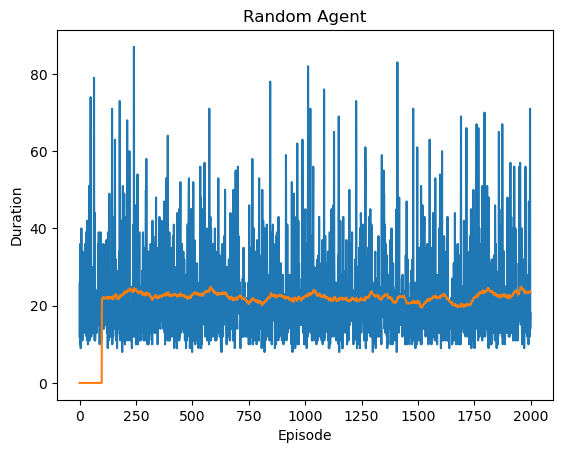

In [11]:
# We fisrt test a random agent by giving random actions to the agent
# we use the plot_duration() function to plot the time the agent survived for each episode

num_episodes = 600

for i_episode in range(num_episodes):

    env.reset()
    for t in count():
        
        action = env.action_space.sample()
        
        _, reward, done, _, _ = env.step(action)

        if done:
            episode_durations.append(t + 1)
            break

plt.ioff()
plot_durations("Random Agent")
plt.show()

episode_durations = []
steps_done = 0

In [12]:
# Let us look at some results of using the random agent
# We use the provided module VideoRecoder by openAI
# This modules save the frame from a render of the environment and turns it into a mp4

#!!! I am using MoviePy for making the mp4, I searched a lot but could not suppress the otuputs from it

video = VideoRecorder(env,path="./video/No_Training.mp4")

done = False
i = 0 

state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

while ((~done) or (i<5000)) :
      
  env.render()
  video.capture_frame()
      
  action = env.action_space.sample()
  observation,reward,done,_,info = env.step(action.item())
  
  #print("step", i, observation, reward, done, info)

  if not done:
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
  else:
    break
  
  i = i+1

video.close()

step 0 [ 0.04473393  0.19367568  0.02141764 -0.26602155] 1.0 False
step 1 [ 0.04860744 -0.0017453   0.0160972   0.033339  ] 1.0 False
step 2 [ 0.04857254 -0.19709435  0.01676399  0.33105698] 1.0 False
step 3 [ 0.04463065 -0.39245087  0.02338512  0.62897897] 1.0 False
step 4 [ 0.03678163 -0.19766293  0.03596471  0.34375155] 1.0 False
step 5 [ 0.03282838 -0.00307059  0.04283974  0.06262314] 1.0 False
step 6 [ 0.03276696 -0.19877975  0.0440922   0.36850855] 1.0 False
step 7 [ 0.02879137 -0.00431113  0.05146237  0.09004804] 1.0 False
step 8 [ 0.02870514 -0.2001315   0.05326333  0.398513  ] 1.0 False
step 9 [ 0.02470252 -0.39596704  0.06123359  0.7075017 ] 1.0 False
step 10 [ 0.01678317 -0.20174439  0.07538363  0.4347052 ] 1.0 False
step 11 [ 0.01274829 -0.00776608  0.08407773  0.16670588] 1.0 False
step 12 [ 0.01259296 -0.20398462  0.08741184  0.48468375] 1.0 False
step 13 [ 0.00851327 -0.01019797  0.09710552  0.22077994] 1.0 False
step 14 [ 0.00830931  0.18341152  0.10152112 -0.03976199] 

Moviepy - Done !
Moviepy - video ready ./video/No_Training.mp4


In [13]:
from IPython.display import HTML

HTML("""
<video controls>
    <source src = "%s" type ="video/mp4">
</video>
"""%"video/No_Training.mp4"
)

#### Agent Trained for 200 Episodes (small amount of time)

In [14]:
# Reinitialize all the needed variables so we can train a agent for a small amount of time

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

In [15]:
# We will train the agent for 150 episodes
# We will use our select_action() function to pick the action ouputed by the netwrok or the randomly generated action
# The we will perform optimization of the policy based on the transitions saved in the memory
# We will update our target_net every TARGET_UPDATE interval

num_episodes = 200
for i_episode in range(num_episodes):
    
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    for t in count():

        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model()
        if done:
            episode_durations.append(t + 1)
            break

        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

print('Complete')

episode_durations = []
steps_done = 0

Complete


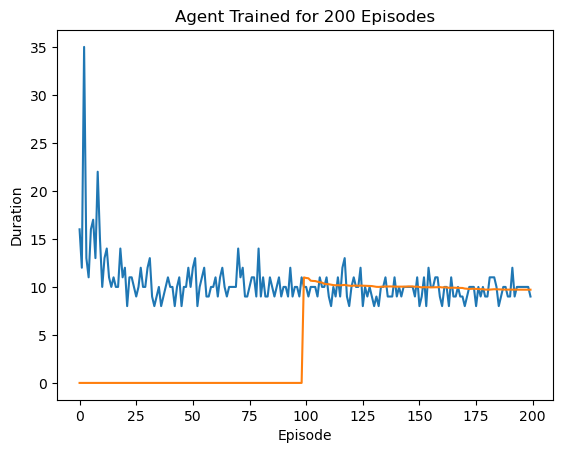

In [16]:
# Next we will check how the agent performs using the plot_duration() function

num_episodes = 200
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())

        last_screen = current_screen
        current_screen = get_screen()
        
        if not done:
            state = current_screen - last_screen
        else:
            episode_durations.append(t + 1)
            break
   

env.render()
plt.ioff()
plot_durations("Agent Trained for 200 Episodes")
plt.show()

episode_durations = []
steps_done = 0

# We see that on average the agent stays alive fro longer duration than the random agent

In [17]:
# We can also visualize how the agent perform using the VideoRecoder module

# Let us look at some results of using the random agent
# We use the provided module VideoRecoder by openAI
# This modules save the frame from a render of the environment and turns it into a mp4

#!!! I am using MoviePy for making the mp4, I searched a lot but could not suppress the otuputs from it

video = VideoRecorder(env,path="./video/No_Training.mp4")

done = False
i = 0 

state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

while (~done or i<5000) :
      
  env.render()
  video.capture_frame()
      
  action = select_action(state)
  observation,reward,done,_,info = env.step(action.item())
  
  #print("step", i, observation, reward, done, info)

  if not done:
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
  else:
    break
  
  i = i+1

video.close()

step 0 [-0.01179529  0.2311088   0.02028464 -0.306235  ] 1.0 False {}
step 1 [-0.00717311  0.4259359   0.01415994 -0.5924522 ] 1.0 False {}
step 2 [ 0.00134561  0.6208568   0.00231089 -0.8806414 ] 1.0 False {}
step 3 [ 0.01376274  0.8159473  -0.01530193 -1.1725969 ] 1.0 False {}
step 4 [ 0.03008169  1.0112648  -0.03875387 -1.4700375 ] 1.0 False {}
step 5 [ 0.05030698  1.2068388  -0.06815462 -1.774569  ] 1.0 False {}
step 6 [ 0.07444376  1.4026595  -0.103646   -2.08764   ] 1.0 False {}
step 7 [ 0.10249695  1.5986638  -0.1453988  -2.4104862 ] 1.0 False {}
step 8 [ 0.13447022  1.4050739  -0.19360852 -2.1657622 ] 1.0 False {}
step 9 [ 0.1625717   1.6014911  -0.23692377 -2.5114493 ] 1.0 True {}
Moviepy - Building video ./video/Trained_200_episodes.mp4.
Moviepy - Writing video ./video/Trained_200_episodes.mp4



Moviepy - Done !
Moviepy - video ready ./video/Trained_200_episodes.mp4


In [24]:
from IPython.display import HTML

HTML("""
<video controls>
    <source src = "%s" type ="video/mp4">
</video>
"""%"video/Trained_200_episodes.mp4"
)

#We takes more step, and try to balance the pole but it still fails

#### Agent Trained for 1000 Episodes (Large amount of time)

In [19]:
# We repeat all the steps and train the agen for a longer time now

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

In [20]:
# This time we will train the agent for 2000 episodes

num_episodes = 1000

for i_episode in range(num_episodes):

    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        last_screen = current_screen
        current_screen = get_screen()
        
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)

        state = next_state
        
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            break

        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

print('Complete')

episode_durations = []
steps_done = 0


Complete


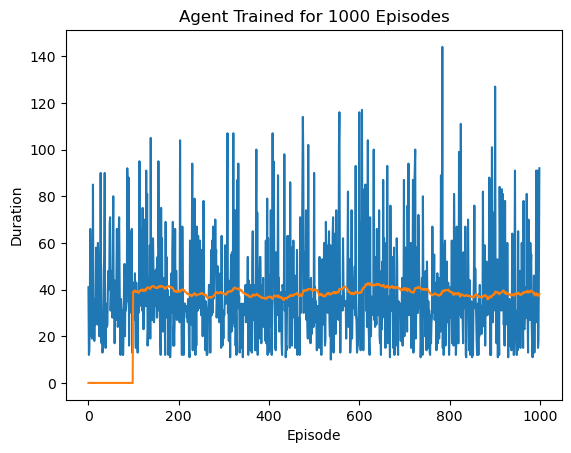

In [21]:

num_episodes = 1000

for i_episode in range(num_episodes):

    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    for t in count():
        

        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())

        last_screen = current_screen
        current_screen = get_screen()
        
        if not done:
            state = current_screen - last_screen
        else:
            episode_durations.append(t + 1)
            break
            

env.render()
plt.ioff()
plot_durations("Agent Trained for 1000 Episodes")
plt.show()

episode_durations = []
steps_done = 0

# We obsevrve that the agent stays alive more than the previous agent on average

In [30]:
video = VideoRecorder(env,path="./video/Trained_1000_episodes.mp4")

done = False
i = 0 

env.reset()
last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen

while (~done) :
      
  env.render()
  video.capture_frame()
      
  action = select_action(state)
  observation,reward,done,_,info = env.step(action.item())
  
  print("step", i, observation, reward, done, info)
  
  # Observe new state
  last_screen = current_screen
  
  current_screen = get_screen()
  if not done:
    state = current_screen - last_screen
  else:
    break
  
  i = i+1

video.close()
env.close()

step 0 [ 0.02003176 -0.22573005  0.00423136  0.27088735] 1.0 False {}
step 1 [ 0.01551716 -0.42091212  0.00964911  0.5649018 ] 1.0 False {}
step 2 [ 0.00709891 -0.22592688  0.02094715  0.27527437] 1.0 False {}
step 3 [ 0.00258038 -0.03110996  0.02645263 -0.01072889] 1.0 False {}
step 4 [ 0.00195818  0.16362284  0.02623806 -0.2949497 ] 1.0 False {}
step 5 [ 0.00523063  0.3583611   0.02033906 -0.5792434 ] 1.0 False {}
step 6 [ 0.01239786  0.5531922   0.00875419 -0.8654504 ] 1.0 False {}
step 7 [ 0.0234617   0.35795218 -0.00855482 -0.5700279 ] 1.0 False {}
step 8 [ 0.03062074  0.16295125 -0.01995537 -0.28005227] 1.0 False {}
step 9 [ 0.03387977 -0.03188043 -0.02555642  0.00627057] 1.0 False {}
step 10 [ 0.03324216 -0.22662672 -0.02543101  0.29078186] 1.0 False {}
step 11 [ 0.02870963 -0.421377   -0.01961537  0.5753369 ] 1.0 False {}
step 12 [ 0.02028208 -0.61621857 -0.00810863  0.8617765 ] 1.0 False {}
step 13 [ 0.00795771 -0.81122917  0.0091269   1.1518989 ] 1.0 False {}
step 14 [-0.0082

Moviepy - Done !
Moviepy - video ready ./video/Trained_1000_episodes.mp4


In [31]:
from IPython.display import HTML

HTML("""
<video controls>
    <source src = "%s" type ="video/mp4">
</video>
"""%"video/Trained_1000_episodes.mp4"
)